In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import seaborn as sns

In [2]:
data = pd.read_csv("./data/heart.csv")

In [3]:
data.shape

(1025, 14)

In [4]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [5]:
healthy_or_not = data['target'].value_counts().to_list()
print(healthy_or_not)

[526, 499]


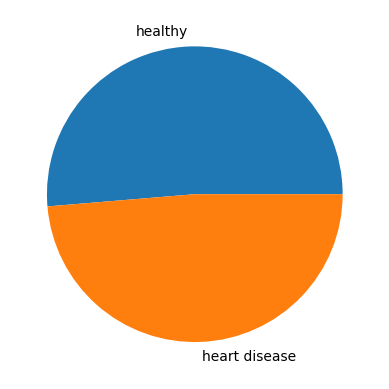

In [6]:
plt.pie(healthy_or_not, labels=['healthy', 'heart disease'])
plt.show()

In [7]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [8]:
numerical_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

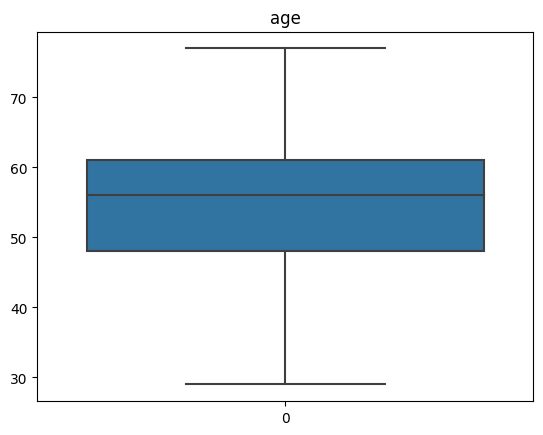

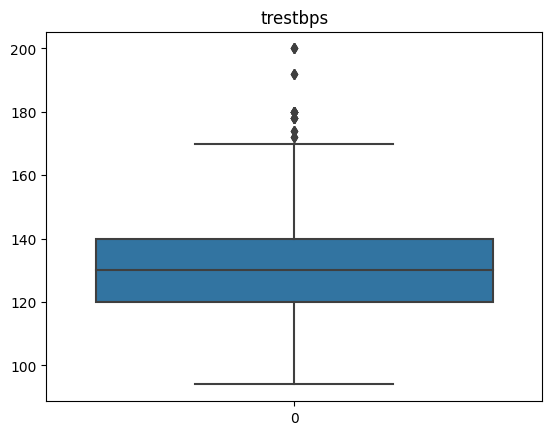

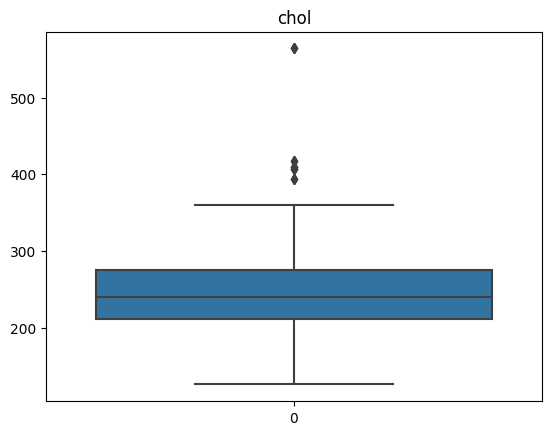

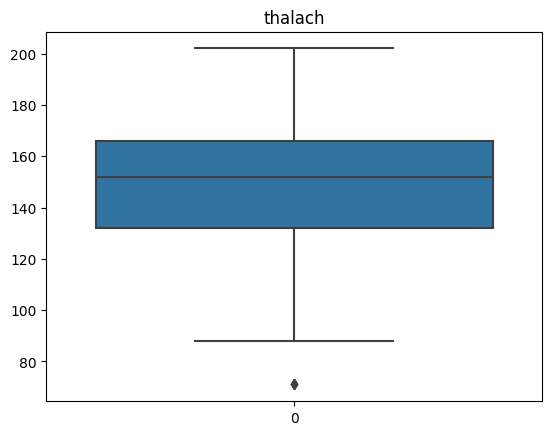

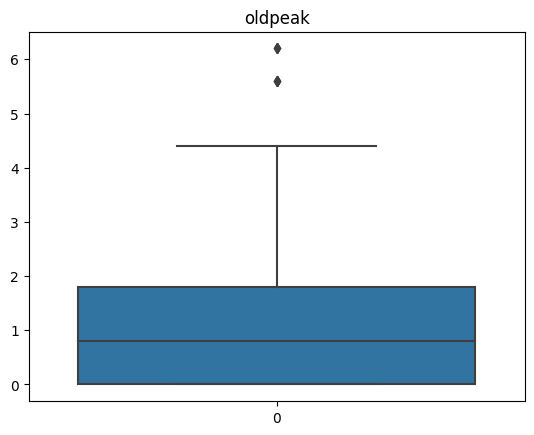

In [9]:
for col in numerical_columns:
    if col != 'target':
        sns.boxplot(data=data[col])
        plt.title(col)
        plt.show()

In [10]:
from collections import Counter
def iqr_method(df, n, features):
    outlier_list = []
    for col in features:
        q1 = np.percentile(df[col], 25)
        q3 = np.percentile(df[col], 75)
        iqr = q3 - q1

        max_limit = q3 + (1.5 * iqr)
        min_limit = q1 - (1.5 * iqr)

        outlier_column_list = df[(df[col] < min_limit) | (df[col] > max_limit)].index
        outlier_list.extend(outlier_column_list)

    outlier_list = Counter(outlier_list)
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    df1 = df[df[col] < min_limit]
    df2 = df[df[col] > max_limit]
    
    print('Total number of outliers is:', df1.shape[0]+df2.shape[0])
    
    return multiple_outliers

In [11]:
outliers = iqr_method(data, 1, numerical_columns)
data = data.drop(outliers, axis=0).reset_index(drop=True)

Total number of outliers is: 7


In [12]:
df = pd.get_dummies(data, drop_first=True)

In [13]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [14]:
x = df.drop('target', axis=1)
y = df['target']

In [15]:
x.shape, y.shape

((1025, 13), (1025,))

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size = 0.3, random_state = 42)

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((717, 13), (717,), (308, 13), (308,))

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
numerical_columns

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [20]:
scaler = StandardScaler().fit(X_train[numerical_columns].values)

In [21]:
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns].values)
X_test[numerical_columns] = scaler.fit_transform(X_test[numerical_columns].values)

In [22]:
X_train.shape

(717, 13)

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten

In [24]:
model = Sequential([
    tensorflow.keras.Input(shape=(13)),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(16, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(8, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(4, activation='relu', kernel_initializer='he_normal'),
    Dense(2, activation='softmax', kernel_initializer='he_normal')
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3584      
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               2

In [26]:
model.compile( optimizer="adam" , loss="binary_crossentropy" , metrics=["accuracy", tensorflow.keras.metrics.AUC()])

In [27]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [28]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=50, batch_size=32, verbose=1)

Epoch 1/50


23/23 [==============================] - 3s 24ms/step - loss: 0.7001 - accuracy: 0.6876 - auc: 0.7057 - val_loss: 0.7120 - val_accuracy: 0.5130 - val_auc: 0.5239
Epoch 2/50
23/23 [==============================] - 0s 8ms/step - loss: 0.5821 - accuracy: 0.8298 - auc: 0.8855 - val_loss: 0.6544 - val_accuracy: 0.6916 - val_auc: 0.7450
Epoch 3/50
23/23 [==============================] - 0s 8ms/step - loss: 0.5299 - accuracy: 0.8396 - auc: 0.9058 - val_loss: 0.6158 - val_accuracy: 0.7825 - val_auc: 0.8287
Epoch 4/50
23/23 [==============================] - 0s 8ms/step - loss: 0.4638 - accuracy: 0.8954 - auc: 0.9517 - val_loss: 0.5580 - val_accuracy: 0.7825 - val_auc: 0.8723
Epoch 5/50
23/23 [==============================] - 0s 7ms/step - loss: 0.4121 - accuracy: 0.9066 - auc: 0.9645 - val_loss: 0.4741 - val_accuracy: 0.8474 - val_auc: 0.9224
Epoch 6/50
23/23 [==============================] - 0s 7ms/step - loss: 0.3705 - accuracy: 0.9121 - auc: 0.9677 - val_loss: 0.4053 - val_accuracy: 0.8

In [29]:
model.predict(X_test)

10/10 [==============================] - 0s 3ms/step


array([[1.00000000e+00, 3.36161515e-11],
       [9.99029160e-01, 9.70803027e-04],
       [8.70349504e-06, 9.99991298e-01],
       [1.90349074e-05, 9.99980927e-01],
       [3.07862865e-05, 9.99969244e-01],
       [2.86797240e-05, 9.99971271e-01],
       [9.99855280e-01, 1.44756748e-04],
       [6.11060977e-06, 9.99993920e-01],
       [1.00000000e+00, 2.88092750e-09],
       [9.38039302e-05, 9.99906182e-01],
       [1.28064959e-04, 9.99871969e-01],
       [9.99999762e-01, 2.77051839e-07],
       [9.99988556e-01, 1.14693803e-05],
       [5.65777782e-06, 9.99994397e-01],
       [5.73706166e-06, 9.99994278e-01],
       [9.99029160e-01, 9.70803027e-04],
       [2.00711911e-05, 9.99979973e-01],
       [9.99999642e-01, 3.90155691e-07],
       [2.45702704e-05, 9.99975443e-01],
       [9.99992132e-01, 7.89561636e-06],
       [1.82667318e-05, 9.99981761e-01],
       [2.52319694e-07, 9.99999762e-01],
       [3.69242656e-07, 9.99999642e-01],
       [1.39682461e-08, 1.00000000e+00],
       [4.899896

In [30]:
import os.path
if os.path.isfile('models/heart1.h5') is False:
    model.save('models/heart1.h5')

In [31]:
history.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x1bc0fa96d70>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.7000597715377808,
   0.5821152329444885,
   0.529864490032196,
   0.4638376533985138,
   0.4120868444442749,
   0.37054017186164856,
   0.3082643449306488,
   0.27036574482917786,
   0.22243110835552216,
   0.18428203463554382,
   0.16060256958007812,
   0.13159415125846863,
   0.12742115557193756,
   0.12232193350791931,
   0.11091859638690948,
   0.10054167360067368,
   0.08480459451675415,
   0.09543221443891525,
   0.0691019594669342,
   0.05499810725450516,
   0.07987762987613678,
   0.09069941192865372,
   0.06358928978443146,
   0.05169184133410454,
   0.07596617937088013,
   0.04684825986623764,
   0.05331539362668991,
   0.06663545966148376,
   0.04230710491538048,
   0.03753431886434555,
   0.04600119590759277,
   0.041405100375413895,
   0.04413396120071411,
   0.0517573282122612,
   0.03907353803515434,


[]

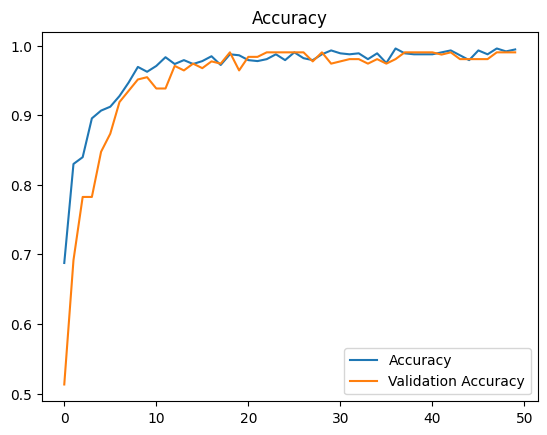

In [34]:
plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.plot()

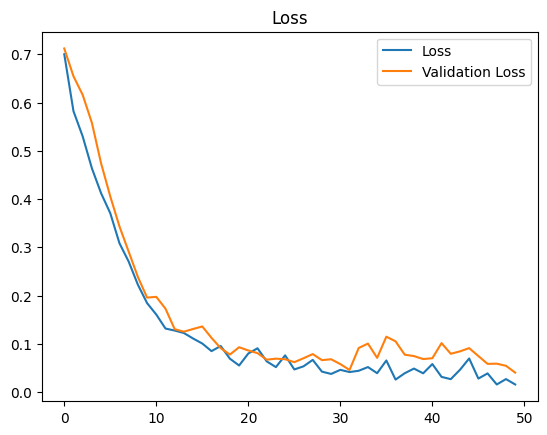

In [35]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.show()